<a href="https://colab.research.google.com/github/emmenets/neuralnetwork/blob/master/190823_rastionlydetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [4]:
cd /content/models/research/

/content/models/research


In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [6]:
!python setup.py build

running build
running build_py
copying object_detection/protos/pipeline_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/faster_rcnn_box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/bipartite_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/faster_rcnn_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/mean_stddev_box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/input_reader_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/hyperparams_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/anchor_generator_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_predictor_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/preprocessor_pb2.py -> build

In [7]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing object_detection.egg-info/PKG-INFO
writing dependency_links to object_detection.egg-info/dependency_links.txt
writing requirements to object_detection.egg-info/requires.txt
writing top-level names to object_detection.egg-info/top_level.txt
writing manifest file 'object_detection.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/object_detection
creating build/bdist.linux-x86_64/egg/object_detection/anchor_generators
copying build/lib/object_detection/anchor_generators/grid_anchor_generator.py -> build/bdist.linux-x86_64/egg/object_detection/anchor_generators
copying build/lib/object_detection/anchor_generators/multiscale_grid_anchor_generator_test.py -> build/bdist.linux-x86_64/egg/object_detection/anchor_generators
copying build/lib/object_detection/anchor_generators/multiple_grid_anchor_

In [0]:
!cp -R /content/models/research/slim/nets /content/models/research/object_detection
!cp -R /content/models/research/slim/deployment /content/models/research/object_detection

In [9]:
cd /content/models/research/object_detection


/content/models/research/object_detection


0
205 1001 317 1160 : 89.03776407241821
{1: {'id': 1, 'name': 'rasti'}}


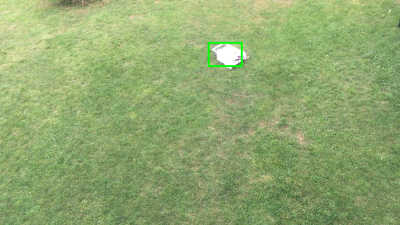

KeyboardInterrupt: ignored

In [34]:
######## Video Object Detection Using Tensorflow-trained Classifier #########
#
# Author: Evan Juras
# Date: 1/16/18
# Description: 
# This program uses a TensorFlow-trained classifier to perform object detection.
# It loads the classifier uses it to perform object detection on a video.
# It draws boxes and scores around the objects of interest in each frame
# of the video.

## Some of the code is copied from Google's example at
## https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

## and some is copied from Dat Tran's example at
## https://github.com/datitran/object_detector_app/blob/master/object_detection_app.py

## but I changed it to make it more understandable to me.

# Import packages
import os
import time
import cv2
import numpy as np
import tensorflow as tf
import sys
import imutils
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
import collections
import glob
import csv


# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Import utilites
from utils import label_map_util
from utils import visualization_utils as vis_util

# Name of the directory containing the object detection module we're using
MODEL_NAME = '/gdrive/My Drive/colabfiles/lektion31/inference_graph'
VIDEO_NAME = '/gdrive/My Drive/colabfiles/lektion31/IMG_4001.MOV'

# Grab path to current working directory
CWD_PATH = os.getcwd()

print(CWD_PATH)

# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = "/gdrive/My Drive/colabfiles/lektion31/inference_graph/frozen_inference_graph.pb"

# Path to label map file
PATH_TO_LABELS = "/gdrive/My Drive/colabfiles/lektion31/label_map.pbtxt"

# Path to video
PATH_TO_VIDEO = os.path.join(CWD_PATH,VIDEO_NAME)

# Number of classes the object detector can identify
NUM_CLASSES = 1

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

# Open video file
video = cv2.VideoCapture(PATH_TO_VIDEO)
print("ok")
i = 0
bildverarbeitnr = 0
lasttime = time.time()
acttime = time.time()
bildnr = 0
while(video.isOpened()):

    # Acquire frame and expand frame dimensions to have shape: [1, None, None, 3]
    # i.e. a single-column array, where each item in the column has the pixel RGB value
    ret, frame = video.read()
    if ret==True:
        
        frame_expanded = np.expand_dims(frame, axis=0)

        # Perform the actual detection by running the model with the image as input
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: frame_expanded})

        #print(boxes)
        try:          
          box = np.squeeze(boxes)
          score = np.squeeze(scores)
          maxscore = max(enumerate(score), key=lambda x: x[1])[0]
          print(maxscore)
          height, width, _ = frame.shape
          
          ymin = (int(box[maxscore,0]*height))
          xmin = (int(box[maxscore,1]*width))
          ymax = (int(box[maxscore,2]*height))
          xmax = (int(box[maxscore,3]*width))
          genauigkeit = (score[maxscore])*100
          print(ymin,xmin,ymax,xmax,":",genauigkeit)
          frame = cv2.rectangle(frame,(xmin,ymin), (xmax,ymax), (0,255,0),8)
          
          print(category_index)
        except:
          pass
        #try:
          #box = np.squeeze(boxes)
          
          #print(box)
          #print(score)
          #maxpos = max(enumerate(score), key=lambda x: x[1])[0]
          #print(maxpos)
          
          
          

          
        #except: 
          #pass

        frame = imutils.resize(frame, 400)
        cv2_imshow(frame)
        time.sleep(1)
        clear_output()
        
        
        #clear_output()
        

        # Press 'q' to quit
        #print(i)
        #i = i + 1
        #if cv2.waitKey(1) == ord('q'):
        #    break
    else:
        break

# Clean up
print("end1")
#video.release()
#cv2.destroyAllWindows()
print("end2")

# New Section

# New Section